# Zadanie zaliczeniowe
Michał Januszkiewicz\
nr albumu: 459089

## Zadanie 1
Utworzyć ramkę danych, która dla każdego leku zawiera następujące informacje:
- unikalny identyfikator leku w bazie DrugBank,
- nazwę leku,
- jego typ,
- opis,
- postać w jakiej dany lek
występuje,
- wskazania,
- mechanizm działania,
- informacje z jakimi pokarmami dany lek
wchodzi w interakcje

In [2]:
import pandas as pd
from bs4 import BeautifulSoup
from networkx.drawing import draw_networkx_nodes
from pandas.io.clipboard import paste


# returns BeautifulSoup object containing database from xml file
def import_database_from_xml(file):
    with open(file) as f:
        drugbank_file = f.read()
    return BeautifulSoup(drugbank_file, 'lxml-xml')


data = import_database_from_xml('drugbank_partial.xml')

In [3]:
# returns DataFrame containing drugs data
# data - BeautifulSoup object containing database
def create_drugs_dataframe(data):
    drugs = []
    for drug in data.find('drugbank').find_all('drug', recursive=False):  # recursive=False is needed because database contains nested drugs
        id = drug.find('drugbank-id', {'primary': 'true'}, recursive=False).text
        name = drug.find('name', recursive=False).text
        type = drug.get('type')
        description = drug.find('description', recursive=False).text
        state = drug.find('state', recursive=False).text
        indications = drug.find('indication', recursive=False).text
        mechanism_of_action = drug.find('mechanism-of-action', recursive=False).text
        food_interactions = [interaction.text for interaction in drug.find('food-interactions', recursive=False).find_all('food-interaction', recursive=False)]

        drugs.append({
            'DrugBank ID': id,
            'Name': name,
            'Type': type,
            'Description': description,
            'State': state,
            'Indications': indications,
            'Mechanism of Action': mechanism_of_action,
            'Food Interactions': food_interactions
        })

    return pd.DataFrame(drugs)

In [4]:
drugs_df = create_drugs_dataframe(data)
drugs_df.head()

,DrugBank ID,Name,Type,Description,State,Indications,Mechanism of Action,Food Interactions
0,DB00001,Lepirudin,biotech,Lepirudin is a recombinant hirudin formed by 6...,solid,Lepirudin is indicated for anticoagulation in ...,Lepirudin is a direct thrombin inhibitor used ...,[Avoid herbs and supplements with anticoagulan...
1,DB00002,Cetuximab,biotech,Cetuximab is a recombinant chimeric human/mous...,liquid,Cetuximab indicated for the treatment of local...,The epidermal growth factor receptor (EGFR) is...,[]
2,DB00003,Dornase alfa,biotech,Dornase alfa is a biosynthetic form of human d...,liquid,Used as adjunct therapy in the treatment of cy...,Dornase alfa is a biosynthetic form of human D...,[]
3,DB00004,Denileukin diftitox,biotech,A recombinant DNA-derived cytotoxic protein co...,liquid,For treatment of cutaneous T-cell lymphoma,Denileukin diftitox binds to the high-affinity...,[]
4,DB00005,Etanercept,biotech,Dimeric fusion protein consisting of the extra...,liquid,Etanercept is indicated for the treatment of m...,There are two distinct receptors for TNF (TNFR...,[]


## Zadanie 2
Utworzyć ramkę danych pozwalającą na wyszukiwanie po DrugBank ID informacji o
wszystkich synonimach pod jakimi dany lek występuje.\
Napisać funkcję, która dla podanego
DrugBank ID utworzy i wyrysuje graf synonimów za pomocą biblioteki NetworkX. Należy
zadbać o czytelność generowanego rysunku.

In [5]:
# returns DataFrame containing synonyms data for all drugs
# data - BeautifulSoup object containing database
def create_synonyms_dataframe(data):
    synonyms = []
    for drug in data.find('drugbank').find_all('drug', recursive=False):
        id = drug.find('drugbank-id', {'primary': 'true'}, recursive=False).text
        name = drug.find('name', recursive=False).text
        synonyms_list = [synonym.text for synonym in
                         drug.find('synonyms', recursive=False).find_all('synonym', recursive=False)]

        synonyms.append({
            'DrugBank ID': id,
            'Name': name,
            'Synonyms': synonyms_list
        })
    return pd.DataFrame(synonyms)

In [6]:
synonyms_df = create_synonyms_dataframe(data)
synonyms_df.head()

,DrugBank ID,Name,Synonyms
0,DB00001,Lepirudin,"[[Leu1, Thr2]-63-desulfohirudin, Desulfatohiru..."
1,DB00002,Cetuximab,"[Cetuximab, Cétuximab, Cetuximabum]"
2,DB00003,Dornase alfa,[Deoxyribonuclease (human clone 18-1 protein m...
3,DB00004,Denileukin diftitox,"[Denileukin, Denileukin diftitox, Interleukin-..."
4,DB00005,Etanercept,"[Etanercept, etanercept-szzs, etanercept-ykro,..."


In [7]:
import networkx as nx
import matplotlib.pyplot as plt

In [8]:
# Draws a graph of synonyms for a given drug
# synonyms_df - DataFrame containing synonyms data for all drugs (generated by create_synonyms_dataframe function)
# drug_id - DrugBank ID of the drug for which the graph should be drawn
def show_synonyms_graph(synonyms_df, drug_id):
    g = nx.Graph()
    synonyms = synonyms_df.loc[synonyms_df['DrugBank ID'] == drug_id, 'Synonyms'].values[0]

    for synonym in synonyms:
        g.add_edge(drug_id, synonym)

    colors = []
    for node in g.nodes:
        if node == drug_id:
            colors.append('lightgreen')
        else:
            colors.append('lightblue')

    plt.figure(figsize=(len(g.nodes) * 0.5 + 6, len(g.nodes) * 0.5 + 6))
    nx.draw(g, with_labels=True, font_size=10, node_size=5000, font_color='black', node_color=colors)
    plt.show()

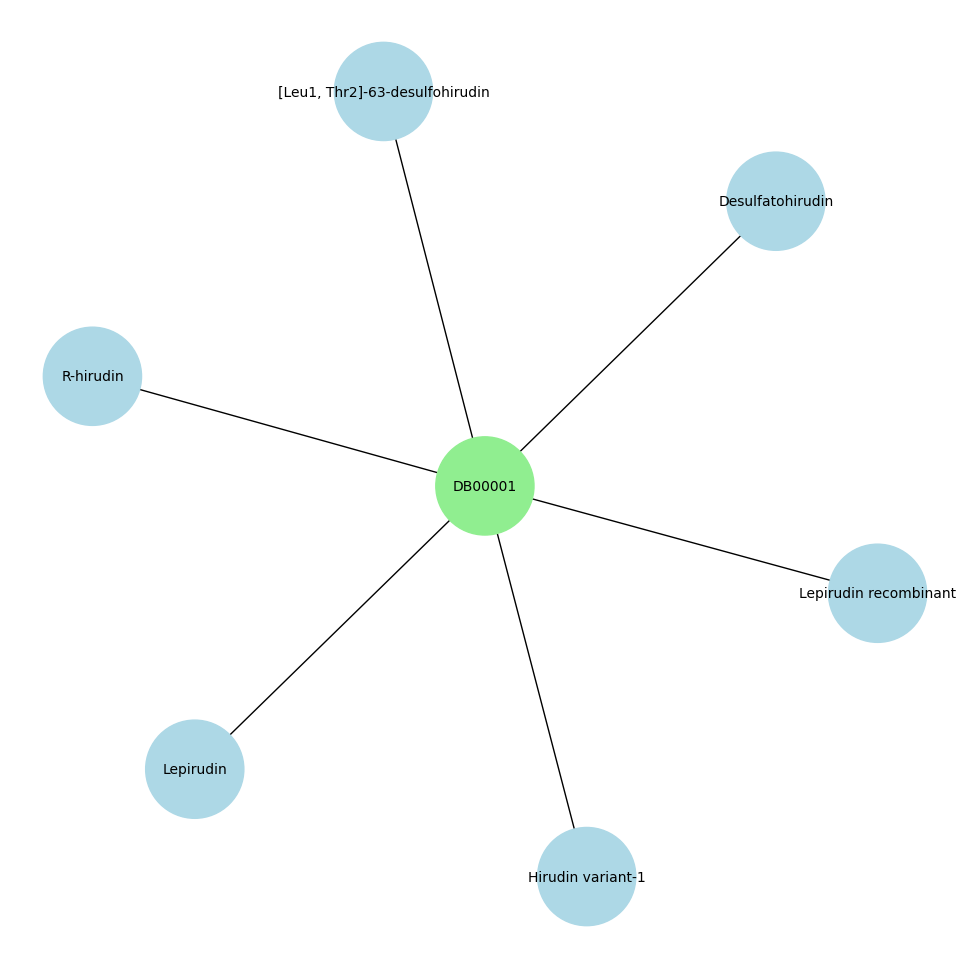

In [9]:
show_synonyms_graph(synonyms_df, 'DB00001')

## Zadanie 3
Utworzyć ramkę danych o produktach farmaceutycznych zawierających dany lek
(substancję leczniczą). Ramka powinna zawierać informacje o:
 - ID leku,
 - nazwie produktu,
 - producencie,
 - kod w narodowym rejestrze USA (ang. *National Drug Code*),
 - postać w jakiej produkt występuje,
 - sposób aplikacji,
 - informacje o dawce,
 - kraju
 - agencji rejestrującej produkt

In [10]:
# returns DataFrame containing pharmaceuticals data
# data - BeautifulSoup object containing database
def create_pharmaceuticals_dataframe(data):
    pharmaceuticals = []
    for drug in data.find('drugbank').find_all('drug', recursive=False):
        id = drug.find('drugbank-id', {'primary': 'true'}, recursive=False).text
        products = drug.find('products', recursive=False)
        if products:
            for product in products.find_all('product', recursive=False):
                name = product.find('name', recursive=False).text
                manufacturer = product.find('labeller', recursive=False).text
                ndc = product.find('ndc-product-code', recursive=False).text
                form = product.find('dosage-form', recursive=False).text
                route = product.find('route', recursive=False).text
                dose = product.find('strength', recursive=False).text
                country = product.find('country', recursive=False).text
                regulatory_authority = product.find('source', recursive=False).text

                pharmaceuticals.append({
                    'DrugBank ID': id,
                    'Product Name': name,
                    'Manufacturer': manufacturer,
                    'NDC': ndc,
                    'Form': form,
                    'Route': route,
                    'Dose': dose,
                    'Country': country,
                    'Regulatory Authority': regulatory_authority
                })

    return pd.DataFrame(pharmaceuticals)

In [11]:
pharmaceuticals_df = create_pharmaceuticals_dataframe(data)
pharmaceuticals_df.head()

,DrugBank ID,Product Name,Manufacturer,NDC,Form,Route,Dose,Country,Regulatory Authority
0,DB00001,Refludan,Bayer,50419-150,Powder,Intravenous,50 mg/1mL,US,FDA NDC
1,DB00001,Refludan,Bayer,,"Powder, for solution",Intravenous,50 mg / vial,Canada,DPD
2,DB00001,Refludan,Celgene Europe Limited,,"Injection, solution, concentrate",Intravenous,50 mg,EU,EMA
3,DB00001,Refludan,Celgene Europe Limited,,"Injection, solution, concentrate",Intravenous,50 mg,EU,EMA
4,DB00001,Refludan,Celgene Europe Limited,,"Injection, solution, concentrate",Intravenous,20 mg,EU,EMA


## Zadanie 4
Utworzyć ramkę danych zawierającą informacje o wszystkich szlakach (sygnałowych,
metabolicznych) z jakimi jakikolwiek lek wchodzi w interakcje. Podać całkowitą liczbę tych
szlaków

In [12]:
# returns DataFrame containing pathways data
# data - BeautifulSoup object containing database
def create_pathways_dataframe(data):
    pathways = []
    for drug in data.find('drugbank').find_all('drug', recursive=False):
        pathways_list = drug.find('pathways', recursive=False)
        if pathways_list:
            for pathway in pathways_list.find_all('pathway', recursive=False):
                pathway_name = pathway.find('name', recursive=False).text
                category = pathway.find('category', recursive=False).text

                pathways.append({
                    'Pathway Name': pathway_name,
                    'Category': category
                })

    return pd.DataFrame(pathways).drop_duplicates()

In [13]:
pathways_df = create_pathways_dataframe(data)
pathways_df.head()

,Pathway Name,Category
0,Lepirudin Action Pathway,drug_action
1,Cetuximab Action Pathway,drug_action
2,Bivalirudin Action Pathway,drug_action
3,Alteplase Action Pathway,drug_action
4,Urokinase Action Pathway,drug_action


In [14]:
print("Total number of pathways:", len(pathways_df))

Total number of pathways: 12


## Zadanie 5
Dla każdego szlaku sygnałowego/metabolicznego w bazie danych podać leki, które
wchodzą z nim w interakcje. Wyniki należy przedstawić w postaci ramki danych jak i w
opracowanej przez siebie formie graficznej. Przykładem takiej grafiki może być graf
dwudzielny, gdzie dwa rodzaje wierzchołków to szlaki sygnałowe i leki, a poszczególne
krawędzie reprezentują interakcję danego leku z danym szlakiem sygnałowym. Należy
zadbać o czytelność i atrakcyjność prezentacji graficznej

In [15]:
# returns DataFrame containing drugs-pathways data
# data - BeautifulSoup object containing database
def create_drugs_pathways_dataframe(data):
    pathways_drugs = []
    for drug in data.find('drugbank').find_all('drug', recursive=False):
        name = drug.find('name', recursive=False).text
        pathways = drug.find('pathways', recursive=False)
        if pathways:
            for pathway in pathways.find_all('pathway', recursive=False):
                pathway_name = pathway.find('name', recursive=False).text

                pathways_drugs.append({
                    'Drug Name': name,
                    'Pathway Name': pathway_name
                })

    return pd.DataFrame(pathways_drugs)

In [16]:
drugs_pathways_df = create_drugs_pathways_dataframe(data)
drugs_pathways_df.head()

,Drug Name,Pathway Name
0,Lepirudin,Lepirudin Action Pathway
1,Cetuximab,Cetuximab Action Pathway
2,Bivalirudin,Bivalirudin Action Pathway
3,Alteplase,Alteplase Action Pathway
4,Urokinase,Urokinase Action Pathway


In [17]:
# Draws a bipartite graph of drugs and pathways
# drugs_pathways_df - DataFrame containing drugs-pathways data (generated by create_drugs_pathways_dataframe function)
def show_drugs_pathways_graph(drugs_pathways_df):
    g = nx.Graph()
    drug_nodes = set(drugs_pathways_df['Drug Name'])
    pathway_nodes = set(drugs_pathways_df['Pathway Name'])

    g.add_nodes_from(drug_nodes, bipartite=0)
    g.add_nodes_from(pathway_nodes, bipartite=1)

    for i, row in drugs_pathways_df.iterrows():
        drug_name = row['Drug Name']
        pathway_name = row['Pathway Name']
        g.add_edge(drug_name, pathway_name)

    pos = nx.drawing.layout.bipartite_layout(g, drug_nodes, align='vertical')

    plt.figure(figsize=(15, max(len(drug_nodes), len(pathway_nodes)) * 1.25))
    nx.draw(g, pos, with_labels=True, font_size=10, node_size=5000, node_shape='h', node_color='lightblue',
            font_color='black', bbox=dict(facecolor='lightblue', edgecolor='lightblue', boxstyle='round,pad=0.5'))
    plt.show()

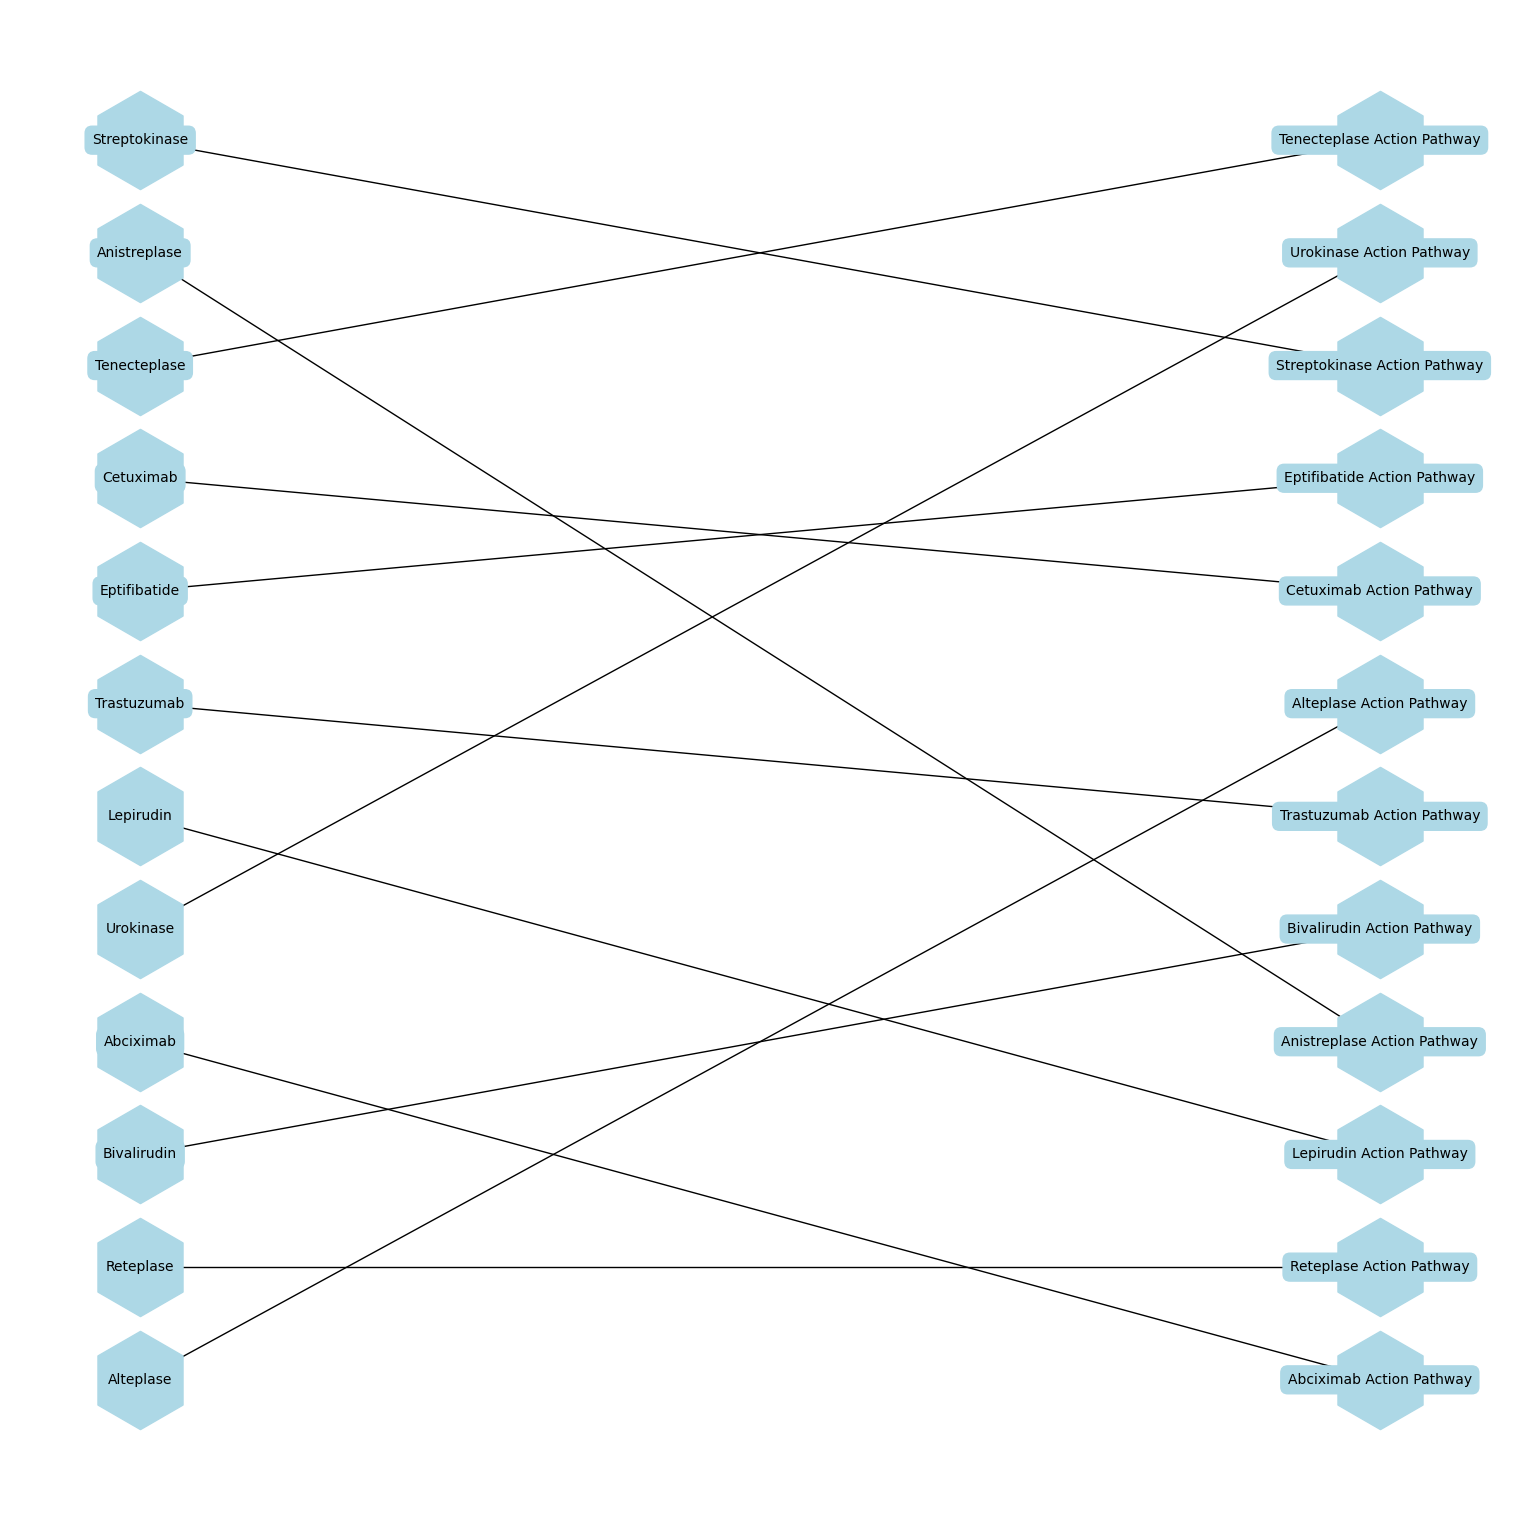

In [18]:
show_drugs_pathways_graph(drugs_pathways_df)

## Zadanie 6
Dla każdego leku w bazie danych podać liczbę szlaków, z którymi dany lek wchodzi w
interakcje. Przedstawić wyniki w postaci histogramu z odpowiednio opisanymi osiami.

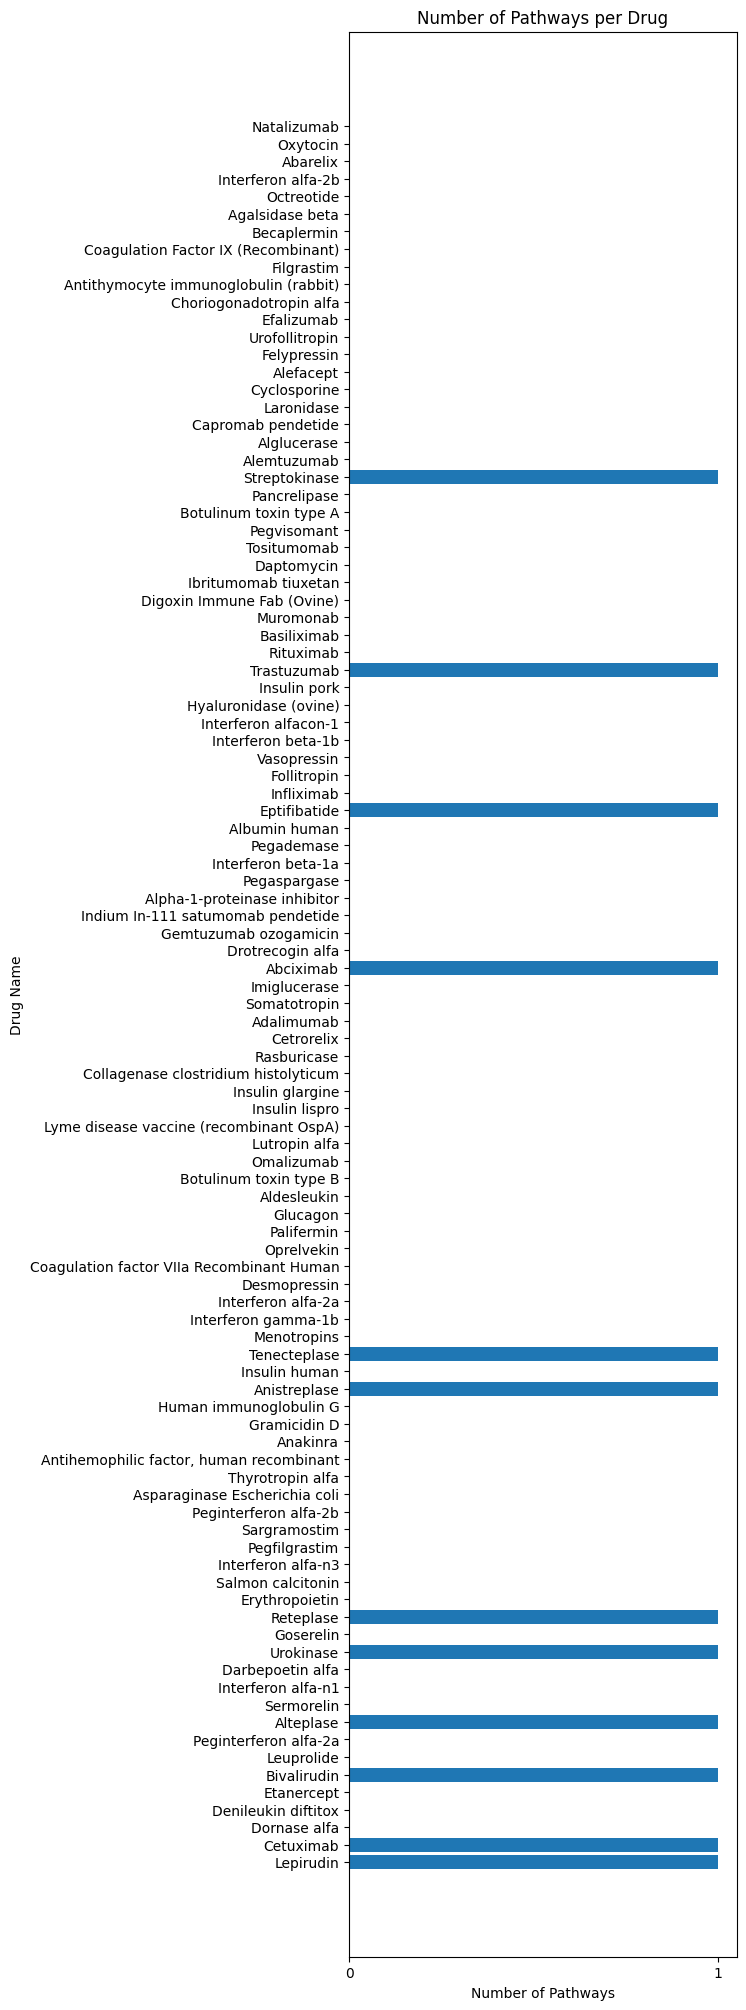

In [19]:
# Draws a histogram showing the number of pathways per drug
# drugs_df - DataFrame containing drugs data (generated by create_drugs_dataframe function)
# drugs_pathways_df - DataFrame containing drugs-pathways data (generated by create_drugs_pathways_dataframe function)
def show_drugs_pathways_histogram(drugs_df, drugs_pathways_df):
    drug_names = []
    pathways_cnts = []
    for drug_name in drugs_df['Name']:
        drug_names.append(drug_name)
        pathways_cnts.append(len(drugs_pathways_df.loc[drugs_pathways_df['Drug Name'] == drug_name]))

    plt.figure(figsize=(5, len(drug_names) / 4))
    plt.barh(drug_names, pathways_cnts)
    plt.xticks(range(0, max(pathways_cnts) + 1))
    plt.ylabel('Drug Name')
    plt.xlabel('Number of Pathways')
    plt.title('Number of Pathways per Drug')
    plt.show()


show_drugs_pathways_histogram(drugs_df, drugs_pathways_df)

## Zadanie 7
Utworzyć ramkę danych zawierającą informacje o białkach, z którymi poszczególne leki
wchodzą w interakcje. Białka te to tzw. targety. Ramka danych powinna zawierać
przynajmniej DrugBank ID targetu, informację o zewnętrznej bazie danych (ang. *source*,
np. Swiss-Prot), identyfikator w zewnętrznej bazie danych, nazwę polipeptydu, nazwę genu
kodującego polipeptyd, identyfikator genu GenAtlas ID, numer chromosomu, umiejscowienie
w komórce.

In [20]:
# returns DataFrame containing targets (only polypeptides) data for drugs
# data - BeautifulSoup object containing database
def create_targets_dataframe(data):
    targets = []
    for drug in data.find('drugbank').find_all('drug', recursive=False):
        drug_id = drug.find('drugbank-id', {'primary': 'true'}, recursive=False).text
        targets_list = drug.find('targets', recursive=False)
        if targets_list:
            for target in targets_list.find_all('target', recursive=False):
                target_id = target.find('id', recursive=False).text
                polypeptide = target.find('polypeptide', recursive=False)
                if polypeptide:
                    polypeptide_source = polypeptide.get('source')
                    polypeptide_external_id = polypeptide.get('id')
                    polypeptide_name = polypeptide.find('name', recursive=False).text
                    polypeptide_gene = polypeptide.find('gene-name', recursive=False).text
                    genatlas_id = None
                    for identifier in polypeptide.find('external-identifiers', recursive=False).find_all('external-identifier', recursive=False):
                        if identifier.find('resource', recursive=False).text == 'GenAtlas':
                            genatlas_id = identifier.find('identifier', recursive=False).text
                    chromosome = polypeptide.find('chromosome-location', recursive=False).text
                    location = polypeptide.find('cellular-location', recursive=False).text

                    targets.append({
                        'DrugBank ID': drug_id,
                        'Target ID': target_id,
                        'Source': polypeptide_source,
                        'External Polypeptide ID': polypeptide_external_id,
                        'Polypeptide Name': polypeptide_name,
                        'Polypeptide Gene': polypeptide_gene,
                        'GenAtlas ID': genatlas_id,
                        'Chromosome': chromosome,
                        'Location': location
                    })

    return pd.DataFrame(targets)


In [21]:
targets_df = create_targets_dataframe(data)
targets_df.head()

,DrugBank ID,Target ID,Source,External Polypeptide ID,Polypeptide Name,Polypeptide Gene,GenAtlas ID,Chromosome,Location
0,DB00001,BE0000048,Swiss-Prot,P00734,Prothrombin,F2,F2,11,Secreted
1,DB00002,BE0000767,Swiss-Prot,P00533,Epidermal growth factor receptor,EGFR,EGFR,7,Cell membrane
2,DB00002,BE0000901,Swiss-Prot,O75015,Low affinity immunoglobulin gamma Fc region re...,FCGR3B,FCGR3B,1,Cell membrane
3,DB00002,BE0002094,Swiss-Prot,P02745,Complement C1q subcomponent subunit A,C1QA,C1QA,1,Secreted
4,DB00002,BE0002095,Swiss-Prot,P02746,Complement C1q subcomponent subunit B,C1QB,C1QB,1,Secreted


## Zadanie 8
Utworzyć wykres kołowy prezentujący procentowe występowanie targetów w różnych
częściach komórki.

In [22]:
# Draws a pie chart showing the percentage of target locations
# targets_df - DataFrame containing targets data (generated by create_targets_dataframe function)
def show_targets_pie_chart(targets_df):
    locations = targets_df['Location'].value_counts()
    total = locations.sum()
    others = locations[locations / total < 0.01].sum()
    locations = locations[locations / total >= 0.01]
    locations['Others'] = others

    plt.figure(figsize=(10, 10))
    plt.pie(locations, labels=locations.index, autopct='%1.1f%%', pctdistance=0.9)
    plt.title('Target Locations')
    plt.show()


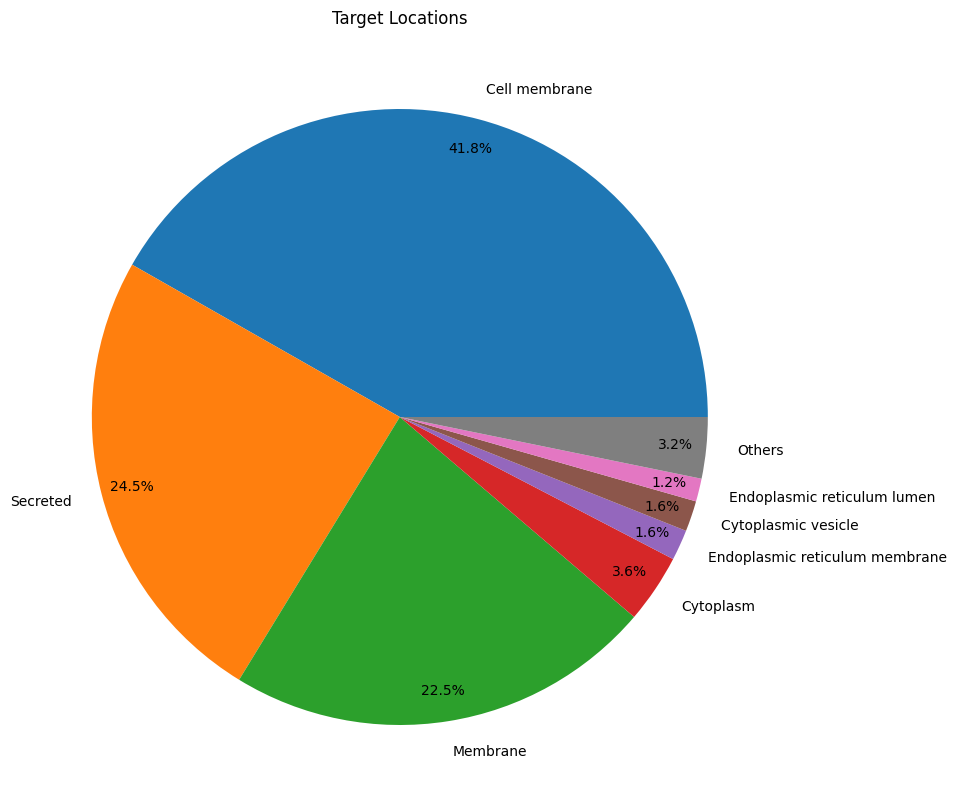

In [23]:
show_targets_pie_chart(targets_df)

## Zadanie 9
Utworzyć ramkę danych, pokazującą ile leków zostało zatwierdzonych, wycofanych, ile
jest w fazie eksperymentalnej (ang. *experimental* lub *investigational*) i dopuszczonych w
leczeniu zwierząt. Przedstawić te dane na wykresie kołowym. Podać liczbę zatwierdzonych
leków, które nie zostały wycofane.

In [24]:
# returns DataFrame containing drug groups data
# data - BeautifulSoup object containing database
def create_drug_groups_dataframe(data):
    drug_statuses = []
    for drug in data.find('drugbank').find_all('drug', recursive=False):
        id = drug.find('drugbank-id', {'primary': 'true'}, recursive=False).text
        for group in drug.find('groups', recursive=False).find_all('group', recursive=False):
            drug_statuses.append({
                'DrugBank ID': id,
                'Status': group.text
            })

    return pd.DataFrame(drug_statuses)

In [25]:
drug_groups_df = create_drug_groups_dataframe(data)
drug_groups_df.head()

,DrugBank ID,Status
0,DB00001,approved
1,DB00001,withdrawn
2,DB00002,approved
3,DB00003,approved
4,DB00004,approved


In [26]:
# Draws a pie chart showing the percentage of drug statuses
# drug_groups_df - DataFrame containing drug groups data (generated by create_drug_groups_dataframe function)
def show_drug_groups_pie_chart(drug_groups_df):
    statuses = drug_groups_df['Status'].value_counts()

    plt.figure(figsize=(10, 10))
    plt.pie(statuses, labels=statuses.index, autopct='%1.1f%%', pctdistance=0.9)
    plt.title('Drug Statuses')
    plt.show()

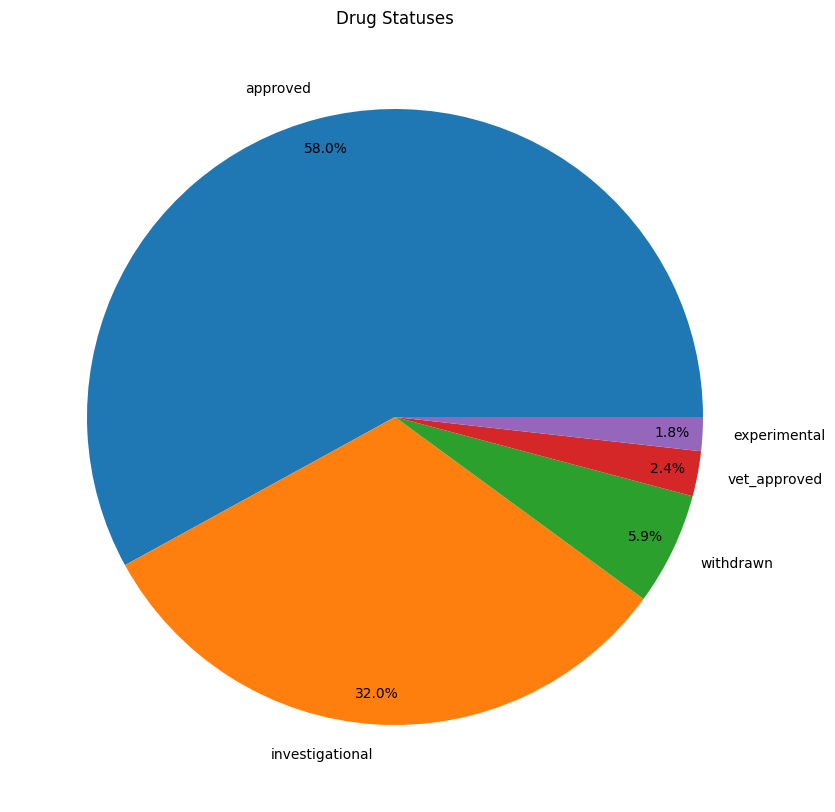

In [27]:
show_drug_groups_pie_chart(drug_groups_df)

In [28]:
approved = drug_groups_df.loc[drug_groups_df['Status'] == 'approved', 'DrugBank ID']
withdrawn = drug_groups_df.loc[drug_groups_df['Status'] == 'withdrawn', 'DrugBank ID']
approved_not_withdrawn = approved[~approved.isin(withdrawn)]
print("Number of approved drugs that were not withdrawn:", len(approved_not_withdrawn))

Number of approved drugs that were not withdrawn: 89


## Zadanie 10
Utworzyć ramkę danych zawierającą informacje dotyczące potencjalnych interakcji danego leku z innymi lekami.

In [29]:
# returns DataFrame containing drug interactions data
# data - BeautifulSoup object containing database
def create_drug_interactions_dataframe(data):
    drug_interactions = []
    for drug in data.find('drugbank').find_all('drug', recursive=False):
        id = drug.find('drugbank-id', {'primary': 'true'}, recursive=False).text
        for interaction in drug.find('drug-interactions', recursive=False).find_all('drug-interaction', recursive=False):
            other_drug_id = interaction.find('drugbank-id', recursive=False).text
            description = interaction.find('description', recursive=False).text
            drug_interactions.append({
                'DrugBank ID': id,
                'Other drug ID': other_drug_id,
                'Description': description
            })

    return pd.DataFrame(drug_interactions)

In [30]:
drug_interactions_df = create_drug_interactions_dataframe(data)
drug_interactions_df.head()

,DrugBank ID,Other drug ID,Description
0,DB00001,DB06605,Apixaban may increase the anticoagulant activi...
1,DB00001,DB06695,Dabigatran etexilate may increase the anticoag...
2,DB00001,DB01254,The risk or severity of bleeding and hemorrhag...
3,DB00001,DB01609,The risk or severity of gastrointestinal bleed...
4,DB00001,DB01586,The risk or severity of bleeding and bruising ...


## Zadanie 11
Opracować według własnego pomysłu graficzną prezentację zawierającą informacje o
konkretnym genie lub genach, substancjach leczniczych, które z tym genem/genami
wchodzą w interakcje, oraz produktach farmaceutycznych, które zawierają daną substancję
leczniczą. Wybór dotyczący tego, czy prezentacja graficzna jest realizowana dla
konkretnego genu, czy wszystkich genów jednocześnie pozostawiamy Państwa decyzji.
Przy dokonywaniu wyboru należy kierować się czytelnością i atrakcyjnością prezentacji
graficznej

In [31]:
# Draws a graph of gene interactions for a given gene
# targets_df - DataFrame containing targets data (generated by create_targets_dataframe function)
# pharmaceuticals_df - DataFrame containing pharmaceuticals data (generated by create_pharmaceuticals_dataframe function)
def show_gene_interactions_graph(targets_df, pharmaceuticals_df, gene_name):
    g = nx.Graph()
    g.add_node(gene_name, part=0)

    drugs = targets_df.loc[targets_df['Polypeptide Gene'] == gene_name]['DrugBank ID']

    for drugbank_id in drugs.values:
        drug_name = drugs_df.loc[drugs_df['DrugBank ID'] == drugbank_id]['Name'].values[0]
        g.add_node(drug_name, part=1)
        g.add_edge(gene_name, drug_name)

        products = pharmaceuticals_df.loc[pharmaceuticals_df['DrugBank ID'] == drugbank_id]['Product Name']
        for product in products:
            g.add_node(product, part=2)
            g.add_edge(drug_name, product)

    colors = []
    for node, part in g.nodes(data='part'):
        if part == 0:
            colors.append('lightgreen')
        elif part == 1:
            colors.append('lightblue')
        else:
            colors.append('lightcoral')

    plt.figure(figsize=(15, 15))
    nx.draw(g, with_labels=True, font_size=10, node_size=5000, node_color=colors)
    plt.show()

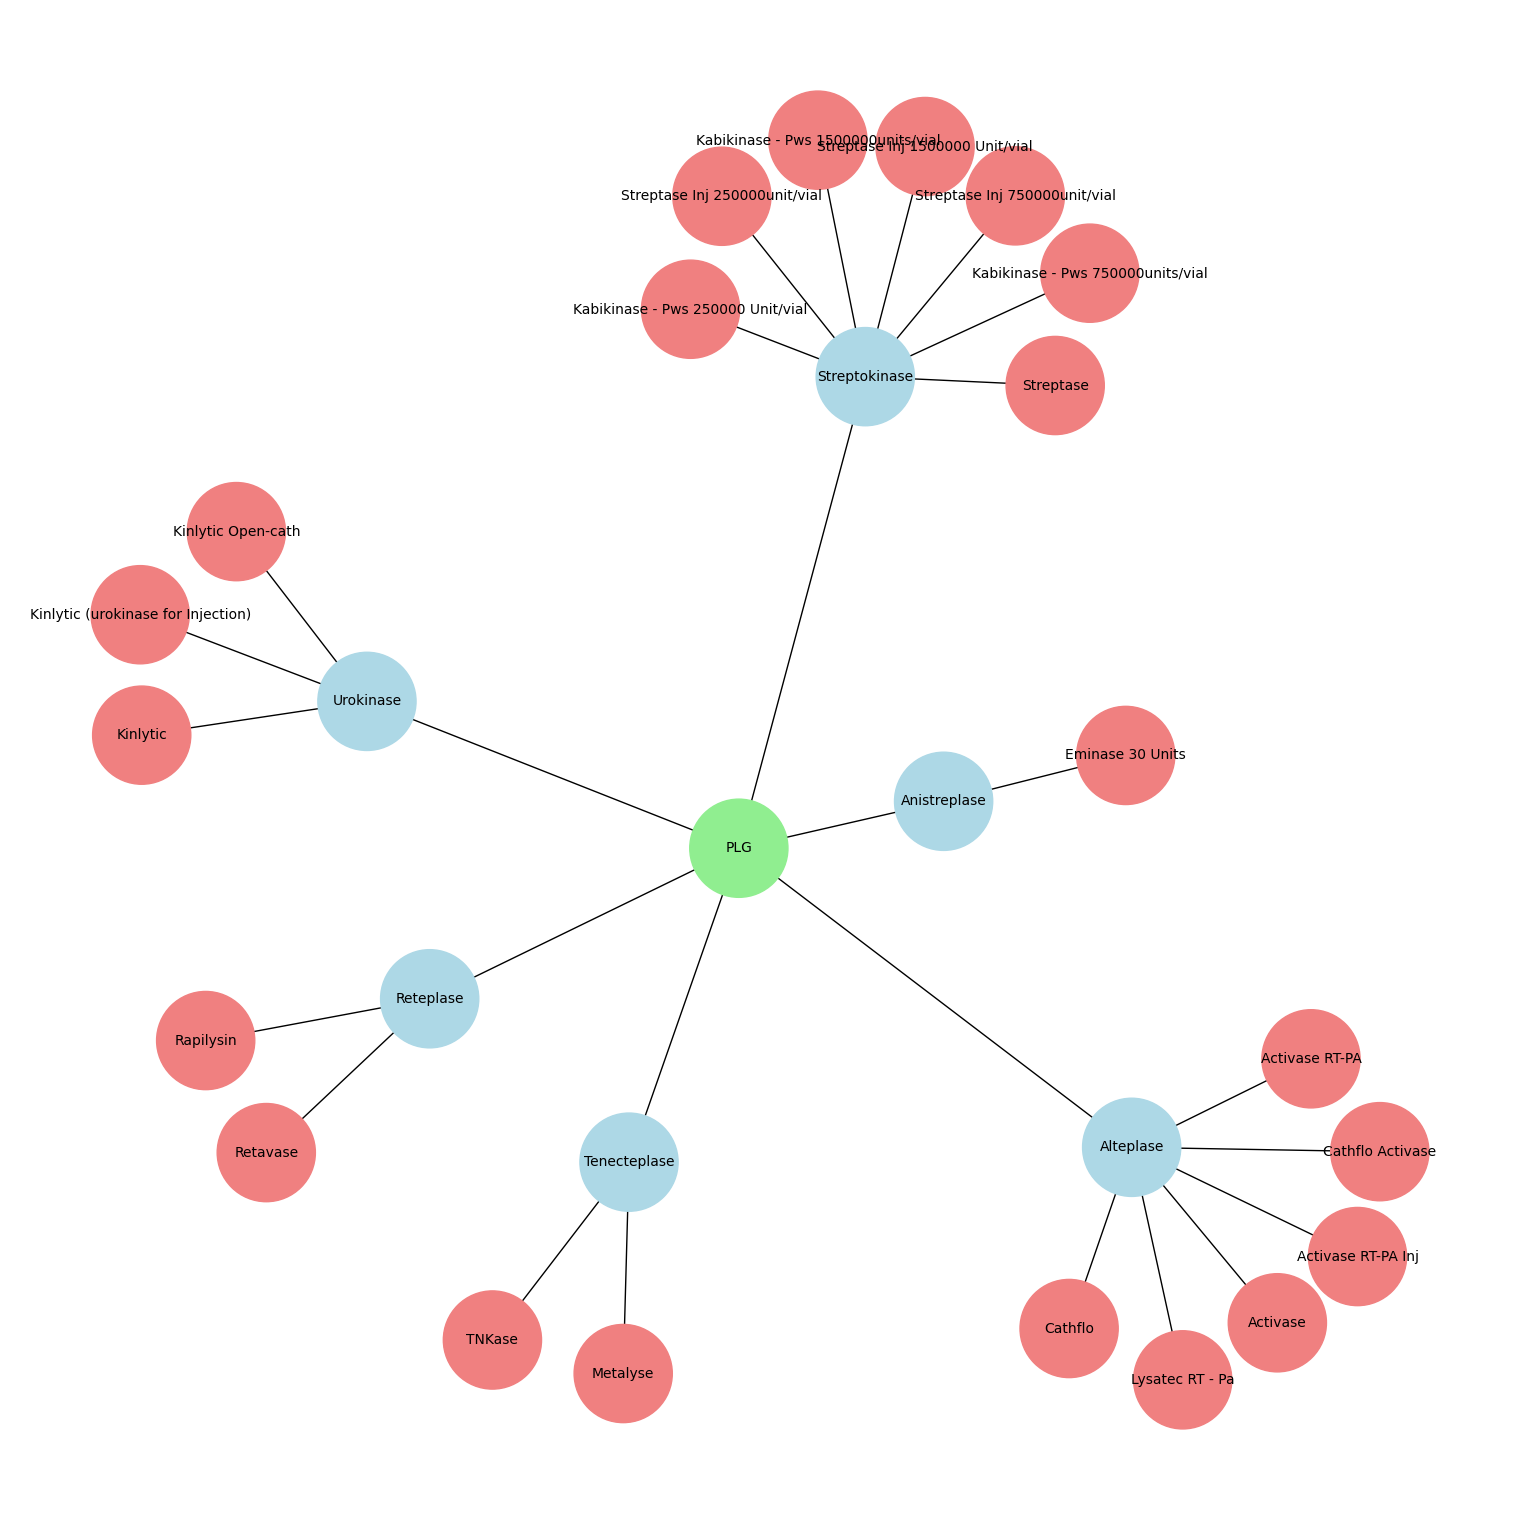

In [32]:
show_gene_interactions_graph(targets_df, pharmaceuticals_df, "PLG")

## Zadanie 12
Zaproponować własną analizę i prezentację danych dotyczących leków. Można w tym
celu pozyskiwać dodatkowe informacje z innych biomedycznych i bioinformatycznych baz
danych dostępnych online. Należy jednak upewnić się, czy dana baza danych pozwala na
zautomatyzowane pobieranie danych przez program. Na przykład baza danych GeneCards
wprost tego zabrania, co zostało na czerwono podkreślone na tej stronie. Przykładowe bazy
danych to: UniProt (https://www.uniprot.org/), Small Molecule Pathway Database
(https://smpdb.ca/), The Human Protein Atlas (https://www.proteinatlas.org/)

#### Analiza ekspresji genu
Dla danego genu z bazy danych The Human Protein Atlas pobieram dane o ekspresji genu w różnych narządach i prezentuję je na wykresie słupkowym.

In [33]:
import requests
import json

In [34]:
# returns Ensembl gene ID for a given gene name
# gene_name - name of the gene
def get_ensembl_gene_id(gene_name):
    url = "https://www.proteinatlas.org/api/search_download.php?search={gene_name}&format=json&columns=g,eg&compress=no"
    response = requests.get(url.format(gene_name=gene_name))
    data = json.loads(response.text)
    for entry in data:
        if entry['Gene'] == gene_name:
            return entry['Ensembl']
    else:
        return None

In [35]:
# returns gene expression data for a given gene name from The Human Protein Atlas
# gene_name - name of the gene
def get_gene_expression_data(gene_name):
    ensembl_gene_id = get_ensembl_gene_id(gene_name)
    url = "https://www.proteinatlas.org/{ensembl_gene_id}.xml"
    response = requests.get(url.format(ensembl_gene_id=ensembl_gene_id))
    soup = BeautifulSoup(response.text, 'lxml-xml')
    expressions = dict()
    for entry in soup.find('rnaExpression', {'source': 'HPA', 'assayType': 'consensusTissue'}).findAll('data'):
        organ = entry.find('tissue').get('organ')
        level = entry.find('level', {'type':'RNAExpression'}).get('expRNA')
        if organ not in expressions:
            expressions[organ] = 0
        expressions[organ] += float(level)
    return expressions

In [36]:
# Draws a heat map from the gene expression data
# gene_name - name of the gene
def show_gene_expression_bar_plot(gene_name):
    expressions = get_gene_expression_data(gene_name)
    plt.figure(figsize=(10, 5))
    plt.bar(expressions.keys(), expressions.values())
    plt.xticks(rotation=90)
    plt.ylabel('Expression Level[TPM]')
    plt.title(f'Gene {gene_name} Expression in Different Organs')
    plt.show()

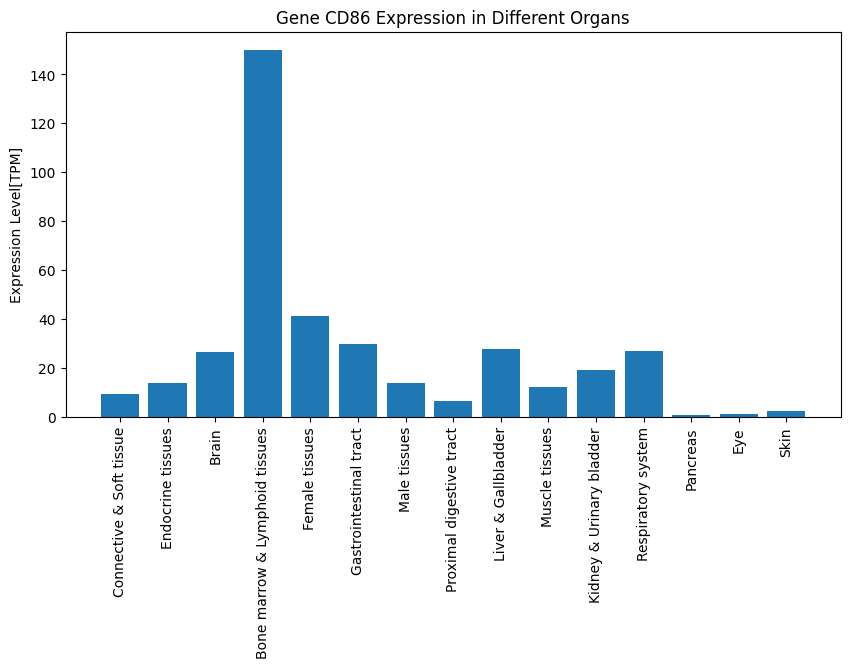

In [37]:
show_gene_expression_bar_plot("CD86")

## Zadanie 13
Stworzyć symulator, który generuje testową bazę 20000 leków. Wartości generowanych
19900 leków w kolumnie “DrugBank Id” powinny mieć kolejne numery, a w pozostałych
kolumnach wartości wylosowane spośród wartości istniejących 100 leków. Zapisz wyniki w
pliku drugbank_partial_and_generated.xml. Przeprowadź analizę według punktów 1-12
testowej bazy

## Zadanie 14
Przygotować testy jednostkowe z pomocą biblioteki pytest.

## Zadanie 15
Zrealizować punkt 6 tak, aby możliwe było wysłanie id leku na Twój serwer, który zwróci
wynik w odpowiedzi (skorzystaj z fastapi i uvicorn; wystarczy zademonstrowanie przesłania
danych metodą POST, przez Execute w dokumentacji)

In [38]:
# uvicorn serwer:app --reload
import requests

def send_request(drug_id):
    url = "http://127.0.0.1:8000/get_pathways_count/"
    response = requests.post(url, json={"drug_id": drug_id})
    return response.json()['pathways_count']

In [39]:
drug_id = 'DB00001'
print(f"Drug {drug_id} interacts with {send_request(drug_id)} pathways")

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=8000): Max retries exceeded with url: /get_pathways_count/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7876d161c4d0>: Failed to establish a new connection: [Errno 111] Connection refused'))